---

<div align=center>

# **Initialisation**

</div>

### Environment

In [1]:
!nvidia-smi

Wed Mar 29 16:08:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:3B:00.0 Off |                    0 |
| N/A   46C    P0    51W / 250W |      0MiB / 22698MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [3]:
# TF config

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dependencies

In [4]:
# Imports

import numpy as np
import tensorflow as tf
from LRFutils import archive, progress
from multiprocess import Pool, cpu_count
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as copy
import pickle
from time import time
import json

2023-03-29 16:08:40.068888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 16:08:41.892787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2023-03-29 16:08:41.892969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2023-03-29 16:08:41.892986: W tensorflow/compiler/tf2tensorrt/ut

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Configuration

In [6]:
# TODO: Edit the config file to match your needs

valid_frac = 0.2
test_frac  = 0.1
dataset_path = "data/dataset"
epochs = 1000
batch_size=100
loss = 'mean_squared_error'
optimizer = 'SGD'
metrics = [
    tf.keras.metrics.MeanAbsoluteError(name="MAE"),
]

### Global variables

In [7]:
# Global variable

archive_path = archive.new(verbose=True)

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

Archive created at ./archives/2023-03-29_46185e4/27


### Useful functions

In [8]:
# Useful functions

def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

def nb_vec(x:dict) -> int:

    for key in x.keys():
        assert len(x[key]) == len(x[list(x.keys())[0]]), "All dictionary element must be the same length"

    return len(x[list(x.keys())[0]])

def get_sample(x):
    sample = {}
    for key, value in x.items():
        sample[key] = value[0]
    return sample

def shuffle(x, y):

    nb_vectors = nb_vec(x)
    assert nb_vec(y) == nb_vectors, "x and y must have the same number of vectors"

    idx = np.random.permutation(nb_vectors)

    x_copy = copy(x)
    for key in x.keys():
        x_copy[key] = x[key][idx]

    y_copy = copy(y)
    for key in y.keys():
        y_copy[key] = y[key][idx]

    return x_copy, y_copy

def pick_vec(x, y, idx):
    vec_x = {}
    for key, value in x.items():
        vec_x[key] = value[idx]
    
    vec_y = {}
    for key, value in y.items():
        vec_y[key] = value[idx]

    return vec_x, vec_y

---

<div align=center>

# **Load data**

</div>

### Read one file

In [9]:
# TODO: Edit the data loading to match your needs

def load_file(file):

    data = np.load(file)

    x = {
        # "Dust wavelenght": np.array([250.,]), # dust observation frequency [um]
        "Dust map" : data["dust_image"].reshape(*data["dust_image"].shape, 1), # adding a channel dimension
        # "CO velocity" : data["CO_v"],
        "CO cube" : data["CO_cube"].reshape(*data["CO_cube"].shape, 1), # adding a channel dimension
        # "N2H+ velocity" : data["N2H_v"],
        # "N2H cube" : data["N2H_cube"].reshape(*data["N2H_cube"].shape, 1), # adding a channel dimension
    }
    
    y = {
        "Total mass" : np.array(data["mass"]),
        "Max temperature" : np.array(np.amax(data["dust_temperature"])),
    }

    return x, y

### Load data

In [10]:
# Loop over files

def load_data() -> tuple[np.ndarray, tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Do what you want int this function, as long as it returns the following:
    - list[3D-ndarray] : input vectors
    - list[3D-ndarray] : output vectors
    """

    # Limit of the number of vectors to load
    max_files = 1000
    files = os.listdir(dataset_path)
    nb_vectors = min(len(files), max_files)

    # Load data
    x = {}
    y = {}
    bar = progress.Bar(nb_vectors, "Loading data")
    for i, file in enumerate(files):
        if i >= nb_vectors:
            break
        bar(i, prefix=system_info())
        
        new_x, new_y = load_file(f"{dataset_path}/{file}")

        for key, value in new_x.items():
            if key not in x:
                x[key] = []
            x[key].append(value)

        for key, value in new_y.items():
            if key not in y:
                y[key] = []
            y[key].append(value)

    
    for key in x.keys():
        x[key] = np.array(x[key])
    
    for key in y.keys():
        y[key] = np.array(y[key])
        
    bar(nb_vectors)    
    return x, y

In [11]:
# Load data

x, y = load_data()
nb_vectors = nb_vec(x)
x_labels = list(x.keys())
y_labels = list(y.keys())
x_shapes = [i[0].shape for i in x.values()]
y_shapes = [i[0].shape for i in y.values()]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:00:232 eta 0:00:00


In [12]:
# Print shapes

print(f"Number of vectors: {nb_vectors}")
print(f"X shapes:\n -", '\n - '.join([f"{i}: {j}" for i, j in zip(x_labels, x_shapes)]))
print(f"Y shapes:\n -", '\n - '.join([f"{i}: {j}" for i, j in zip(y_labels, y_shapes)]))   

Number of vectors: 1000
X shapes:
 - Dust map: (64, 64, 1)
 - CO cube: (64, 64, 128, 1)
Y shapes:
 - Total mass: ()
 - Max temperature: ()


### Plot 10 random input vector 

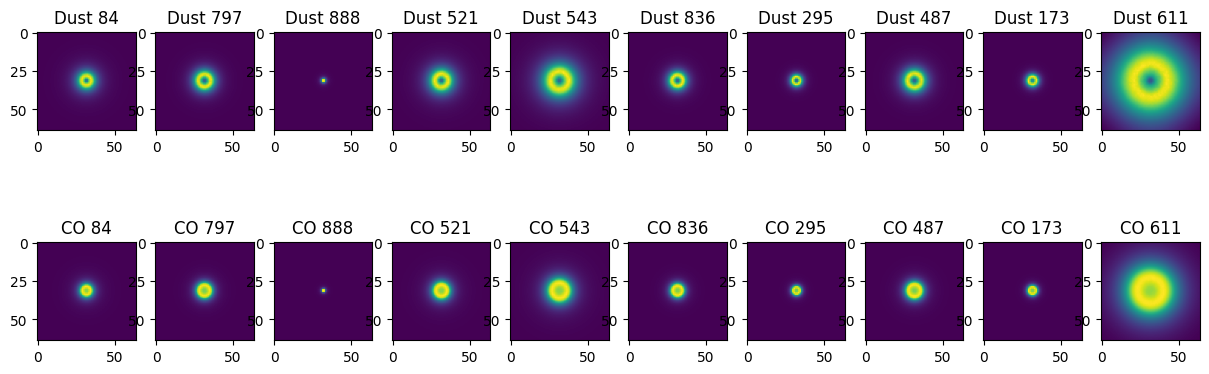

In [13]:
# Human dataset check

if is_notebook():

    nb_axs = 0
    if "Dust map" in x: nb_axs += 1
    if "CO cube" in x: nb_axs += 1
    if "N2H cube" in x: nb_axs += 1

    fig, axs = plt.subplots(nb_axs, 10, figsize=(15, 5))
    if nb_axs == 1: axs = np.array([axs])

    for i in range(10):
        vec = np.random.randint(0, nb_vectors+1)
        nb_axis = 0
        if "Dust map" in x:
            axs[nb_axis, i].imshow(x["Dust map"][vec])
            axs[nb_axis, i].set_title(f"Dust {vec}")
            nb_axis += 1
        if "CO cube" in x:
            axs[nb_axis, i].imshow(np.sum(x["CO cube"][vec], axis=(-1,-2)))
            axs[nb_axis, i].set_title(f"CO {vec}")
            nb_axis += 1
        if "N2H cube" in x:
            axs[nb_axis, i].imshow(np.sum(x["N2H cube"][vec], axis=(-1,-2)))
            axs[nb_axis, i].set_title(f"N2H+ {vec}")
            nb_axis += 1

---

<div align=center>

# **Post processing**

</div>

### Normalisation

In [14]:
# Normalization

def normalize(x):

    x_maxs = {}
    for key, value in x.items():
        x_maxs[key] = np.max(value)
        x[key] /= x_maxs[key]

    return x_maxs

x_maxs = normalize(x)
y_maxs = normalize(y)

In [15]:
# Print

print("Maximum values:")
pd.DataFrame.from_records([x_maxs | y_maxs, ])

Maximum values:


,Dust map,CO cube,Total mass,Max temperature
0,1154.924316,7.644677,2.103129e+06,14.589241


### Splitting datasets

In [16]:
# Splitting dataset

def split(x, y, valid_frac=0.2, test_frac=0.1):

    nb_vectors = nb_vec(x)
    train_frac = 1 - valid_frac - test_frac
    
    train_x, valid_x, test_x = {}, {}, {}

    for key, value in x.items():
        train_x[key] = value[:int(nb_vectors*train_frac)]
        valid_x[key] = value[int(nb_vectors*train_frac):int(nb_vectors*(train_frac+valid_frac))]
        test_x[key] = value[int(nb_vectors*(train_frac+valid_frac)):]

    train_y, valid_y, test_y = {}, {}, {}

    for key, value in y.items():
        train_y[key] = value[:int(nb_vectors*train_frac)]
        valid_y[key] = value[int(nb_vectors*train_frac):int(nb_vectors*(train_frac+valid_frac))]
        test_y[key] = value[int(nb_vectors*(train_frac+valid_frac)):]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

x, y = shuffle(x, y)

train_x, train_y, valid_x, valid_y, test_x, test_y = split(x, y, valid_frac, test_frac)

print(f"Train set: {nb_vec(train_x)} vectors")
print(f"Valid set: {nb_vec(valid_x)} vectors")
print(f"Test set: {nb_vec(test_x)} vectors")

Train set: 700 vectors
Valid set: 200 vectors
Test set: 100 vectors


---

<div align=center>

# **Model definition**

</div>

### Build model

In [21]:
# TODO: Edit the model to fit your needs

from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Reshape, Conv3DTranspose, Flatten, Concatenate, Dropout
from keras.models import Model

def get_model(sample):

    # Inputs ------------------------------------------------------------------

    inputs = {}
    for key, value in sample.items():
        inputs.update({key: Input(shape=value.shape, name=key)})

    # Network -----------------------------------------------------------------

    x = Conv2D(16, (8, 8), activation='relu', padding='same', name="Dust_map_conv_1")(inputs["Dust map"])
    x = MaxPooling2D((4, 4), padding='same', name="Dust_map_max_pool_1")(x)
    x = Conv2D(8, (4, 4), activation='relu', padding='same', name="Dust_map_conv_2")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Dust_map_max_pool_2")(x)
    x = Flatten(name="Dust_map_flatting")(x)

    # x2 = Conv3D(16, (8, 8, 8), activation='relu', padding='same', name="CO_cube_conv_1")(inputs["CO cube"])
    # x2 = MaxPooling3D((4, 4, 4), padding='same', name="CO_cube_max_pool_1")(x2)
    # x2 = Conv3D(8, (4, 4, 4), activation='relu', padding='same', name="CO_cube_conv_2")(x2)
    # x2 = MaxPooling3D((2, 2, 2), padding='same', name="CO_cube_max_pool_2")(x2)
    # x2 = Flatten(name="CO_cube_flatting")(x2)

    # x = Concatenate(name="Concatenation")([x, x2])

    x = Dense(4, activation='relu', name="Total_mass_dense")(x)

    # x_mass = Dense(128, activation='relu', name="Total_mass_dense")(x)
    total_mass = Dense(1, activation='relu', name="Total_mass")(x)
    
    # x_temp = Dense(128, activation='relu', name="Max_temperature_dense")(x)
    max_temp = Dense(1, activation='relu', name="Max_temperature")(x)

    # Outputs -----------------------------------------------------------------

    outputs = {
        "Total mass" : total_mass,
        "Max temperature" : max_temp,
    }

    return Model(inputs, outputs)

### Compile model and get summary

In [22]:
# Compiling model

model = get_model(get_sample(x))

def tf_pearson(y_true, y_pred):
    return tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)[1]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Store and print model summary
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Dust map (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 Dust_map_conv_1 (Conv2D)       (None, 64, 64, 16)   1040        ['Dust map[0][0]']               
                                                                                                  
 Dust_map_max_pool_1 (MaxPoolin  (None, 16, 16, 16)  0           ['Dust_map_conv_1[0][0]']        
 g2D)                                                                                             
                                                                                                  
 Dust_map_conv_2 (Conv2D)       (None, 16, 16, 8)    2056        ['Dust_map_max_pool_1[0][0]

### Training model

In [23]:
# Creating progress bar

bar = progress.Bar(epochs)
stage=0

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global bar
        bar(epoch, prefix = f"Loss: {logs['loss']:.2e}")

In [24]:
# Trining model

bar(0)

start_time = time()

history = model.fit(train_x, train_y,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(valid_x, valid_y), 
                    verbose=0,
                    callbacks=[CustomCallback()],
                    workers=10,
                    use_multiprocessing=True)

training_time = time() - start_time

In [25]:
# Saving model

model.save(f'{archive_path}/model0.h5')
with open(f'{archive_path}/history.pickle', "wb") as file_pi:
    pickle.dump(history.history, file_pi)
bar(epochs)

score = model.evaluate(test_x, test_y, verbose=0)
print("Score:", score)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:04:31
Score: [0.02544543705880642, 8.622581844974775e-06, 0.02543681301176548, 0.002399340970441699, 0.11840564757585526]


### Show training history

dict_keys(['loss', 'Max_temperature_loss', 'Total_mass_loss', 'Max_temperature_MAE', 'Total_mass_MAE', 'val_loss', 'val_Max_temperature_loss', 'val_Total_mass_loss', 'val_Max_temperature_MAE', 'val_Total_mass_MAE'])


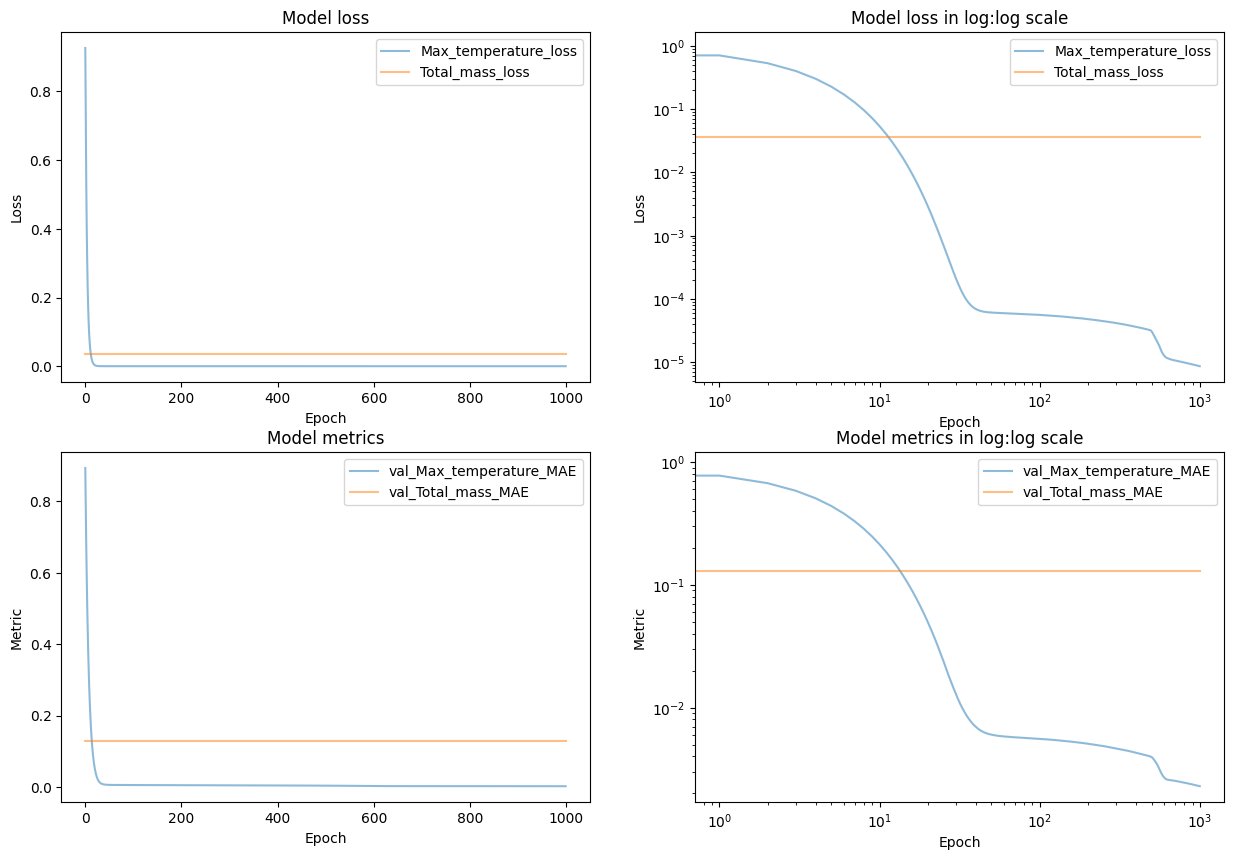

In [26]:
# Show trining history

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for key in history.history.keys():
    if (not key.startswith('val_')) and (key.endswith('_loss')):
        plt.plot(history.history[key], alpha=0.5, label=key.replace(" ", ""))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
for key in history.history.keys():
    if (not key.startswith('val_')) and (key.endswith('_loss')):
        plt.plot(history.history[key], alpha=0.5, label=key.replace(" ", ""))
plt.title('Model loss in log:log scale')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.xscale('log')
plt.yscale('log')

print(history.history.keys())

plt.subplot(2, 2, 3)
for key in history.history.keys():
    if (key.startswith('val_')) and (not key.endswith('_loss')):
        plt.plot(history.history[key], alpha=0.5, label=key.replace(" ", ""))
plt.title('Model metrics')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
for key in history.history.keys():
    if (key.startswith('val_')) and (not key.endswith('_loss')):
        plt.plot(history.history[key], alpha=0.5, label=key.replace(" ", ""))
plt.title('Model metrics in log:log scale')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.show()

### Save model

In [27]:
# Save details

with open(f"{archive_path}/model_details.json", "w") as fp:

    json.dump({
        "summary": short_model_summary,
        "loss": loss,   
        "optimizer": optimizer,
        "metrics": [str(i) for i in metrics],
        "valid_frac": valid_frac,
        "test_frac": test_frac,
        "epochs": epochs,
        "batch_size": batch_size,
        "training_time": training_time,
        "score": score,
        "dataset_size": nb_vectors,
        "path": archive_path,
        "inputs": [str(i) for i in x.keys()],
        "outputs": [str(i) for i in y.keys()],
    }, fp, indent=4)

In [28]:
# Add record to comparison file

for key in y.keys():
    file_path = f"data/model_comparison/{key.replace(' ','_')}.txt"

    with open(file_path, "a") as text_file:
            text_file.write(f"{archive_path}\n")

# Detailed

inputs_txt = ','.join(x_labels).replace(' ', '_')
outputs_txt = ','.join(y_labels).replace(' ', '_')

file_path = f"data/model_comparison/detailed/{inputs_txt}---{outputs_txt}.txt"

with open(file_path, "a") as text_file:
        text_file.write(f"{archive_path}\n")

---

<div align=center>

# **Predictions**

</div>

In [ ]:
r = np.random.randint(0, nb_vectors+1)
x_prediction, y_expected = pick_vec(x, y, r)
print(x_prediction.shape)

y_prediction = model.predict(x_prediction)[0,0]
print(y_prediction.shape)

print(f"Expected: {y_expected * y_maxs[0]:.2e} Msun")
print(f"Predicted: {y_prediction * y_maxs[0]:.2e} Msun")

np.savez_compressed(f'{archive_path}/prediction.npz', x=x_prediction, y=y_prediction, expected=y_expected)